# 1. Cluster Analysis

## Imports and Display Settings

In [131]:
import pandas as pd
import string
import regex as re
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install pyshp
!pip install geopandas
import shapefile as shp
import geopandas as gpd
%matplotlib inline

# Set Seaborn theme
sns.set_theme(context='talk', style='whitegrid', palette='summer', font_scale=0.75, color_codes=True, rc=None)

# Set iPython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

## Downloading and Extracting Dataset Cleaned in Part 1

In [132]:
!gdown --id 1cU-X5C2L-VdQ5-L7GZU3Py7eqX_KFBoU

Downloading...
From: https://drive.google.com/uc?id=1cU-X5C2L-VdQ5-L7GZU3Py7eqX_KFBoU
To: /content/final_crime_dataframe.csv
445MB [00:03, 117MB/s]


## Data Preprocessing

Reading dataset into dataframe

In [133]:
df_crime = pd.read_csv('/content/final_crime_dataframe.csv')

Grouping DataFrame by District and Crime Type

In [134]:
df_cluster = (df_crime.groupby(["District", "Crime"]).agg('count'))

In [135]:
df_cluster = df_cluster[['Month']]

In [136]:
df_cluster.rename(columns = {'Month':'Count'}, inplace=True)

In [137]:
df_cluster = (df_cluster.pivot_table('Count', ['District'], 'Crime')).reset_index()

df_cluster: Contains count of each crime type district wise

In [138]:
df_cluster.head(5)

Crime,District,Anti-social behaviour,Criminal damage and arson,Drugs,Possession of weapons,Robbery,Violence and sexual offences
0,Adur,1204.0,471.0,133.0,26.0,22.0,1033.0
1,Allerdale,1970.0,1016.0,156.0,34.0,17.0,1563.0
2,Amber Valley,3957.0,852.0,199.0,36.0,31.0,1300.0
3,Arun,3403.0,1112.0,255.0,99.0,56.0,2651.0
4,Ashfield,3188.0,1263.0,182.0,62.0,69.0,2473.0


Checking if come districts have no records of a specific crime type

In [139]:
df_cluster.isnull().sum()

Crime
District                        0
Anti-social behaviour           0
Criminal damage and arson       0
Drugs                           0
Possession of weapons           1
Robbery                         2
Violence and sexual offences    0
dtype: int64

Replacing NaN with Zero to indicate no record of a crime

In [140]:
df_cluster = df_cluster.fillna(0.0)

In [141]:
df_cluster.isnull().sum()

Crime
District                        0
Anti-social behaviour           0
Criminal damage and arson       0
Drugs                           0
Possession of weapons           0
Robbery                         0
Violence and sexual offences    0
dtype: int64

Printing summary of data in order to ensure that each crime type is filled for every district. i.e. 348 Districts should have 348 values for crime

In [142]:
df_cluster.describe()

Crime,Anti-social behaviour,Criminal damage and arson,Drugs,Possession of weapons,Robbery,Violence and sexual offences
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4345.267241,1412.454023,341.459770,83.540230,157.385057,3279.077586
std,3789.438223,1242.531306,365.269899,91.669473,313.978681,2945.814276
min,17.000000,6.000000,3.000000,0.000000,0.000000,18.000000
25%,1955.000000,666.750000,125.500000,28.000000,22.000000,1417.000000
50%,3108.500000,1036.000000,225.000000,53.000000,50.500000,2325.500000
75%,5556.250000,1761.750000,383.250000,111.000000,128.750000,4451.000000
max,29611.000000,9438.000000,2980.000000,764.000000,2972.000000,22344.000000


## K-Means Clustering

Normalizing the data for K-Means

In [143]:
df_values = df_cluster.loc[:, df_cluster.columns != 'District'].values
standardized = preprocessing.scale(df_values)
print(standardized)
df_values = pd.DataFrame(standardized)

[[-0.83014688 -0.75878137 -0.5715224  -0.62859619 -0.43181275 -0.76356195]
 [-0.62771504 -0.31952907 -0.50846459 -0.54120047 -0.44776032 -0.58338659]
 [-0.1026079  -0.45170774 -0.39057392 -0.51935154 -0.40310711 -0.67279436]
 ...
 [-0.21360186 -0.48717031 -0.70586293 -0.74876529 -0.47008693 -0.53545314]
 [-0.15414081 -0.49039418 -0.47282323 -0.28993779 -0.38397001 -0.33522053]
 [ 0.90532296  0.01172359  0.38531122 -0.33363565 -0.32336922 -0.1094914 ]]


Finding optimal number of clusters for analysis using Elbow-Curve Method

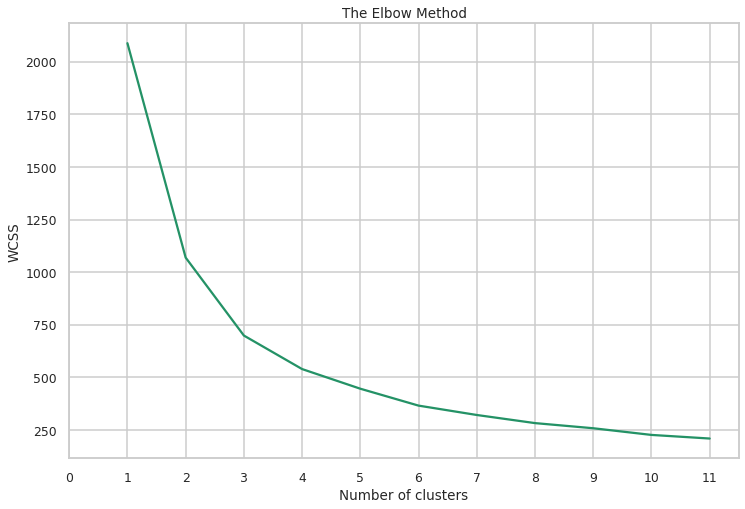

In [144]:
plt.figure(figsize=(12, 8))
wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_values)
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 12), wcss)
plt.xticks(np.arange(0, 12, 1.0))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We can observe that the optimal number of clusters is 3 for this dataset

Predicting using K-Means Algorithm

In [145]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df_values)

In [146]:
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1
# New list called cluster
cluster = list(y_kmeans1)

Assigning cluster value to each district

In [147]:
df_cluster['Cluster'] = cluster

In [148]:
df_cluster.sample(5)

Crime,District,Anti-social behaviour,Criminal damage and arson,Drugs,Possession of weapons,Robbery,Violence and sexual offences,Cluster
292,Taunton Deane,2518.0,769.0,114.0,28.0,39.0,2356.0,1
246,Sevenoaks,1593.0,994.0,124.0,19.0,39.0,1878.0,1
337,Woking,2401.0,721.0,200.0,45.0,18.0,1691.0,1
138,High Peak,2539.0,571.0,129.0,23.0,13.0,936.0,1
261,South Northamptonshire,1552.0,354.0,49.0,8.0,20.0,802.0,1


## Results: Cluster Analysis

In [149]:
kmeans_mean_cluster = pd.DataFrame(round(df_cluster.groupby('Cluster').mean(),1))
kmeans_mean_cluster

Crime,Anti-social behaviour,Criminal damage and arson,Drugs,Possession of weapons,Robbery,Violence and sexual offences
Cluster,,,,,,
1,2729.3,906.6,193.7,51.0,47.8,1994.4
2,8277.9,2582.0,715.8,158.0,425.1,6398.2
3,21549.0,7628.0,1716.2,492.8,1310.5,17055.8


We can observe the following from the clusters generated:


*   Cluster 1: Districts with low counts of crime for all crime types.
*   Cluster 2: Districts with moderate counts of crime for all crime types.
*   Cluster 3: Districts with very high counts of crime for all crime types.



Districts in Cluster 3 (Very High Crime)

In [150]:
cluster_3_df = df_cluster[df_cluster['Cluster'] == 3]
cluster_3_df[['District', 'Cluster']]

Crime,District,Cluster
18,Birmingham,3
28,Bradford,3
159,Leeds,3
165,Liverpool,3
170,Manchester,3
247,Sheffield,3


In [151]:
print('Number of Districts with Very High Crime:', len(df_cluster[df_cluster['Cluster'] == 3]))
print('Number of Districts with Moderate Crime:', len(df_cluster[df_cluster['Cluster'] == 2]))
print('Number of Districts with Low Crime:', len(df_cluster[df_cluster['Cluster'] == 1]))

Number of Districts with Very High Crime: 6
Number of Districts with Moderate Crime: 81
Number of Districts with Low Crime: 261


## Cluster Visualization on Geo Map (Bonus)

Adding cluster information to crime dataset that contains location information

In [152]:
cluster_mappings = dict(zip(df_cluster.District, df_cluster.Cluster))
district_list = df_crime['District']
cluster = []
for district in district_list:
  try:
    val = cluster_mappings[district]
    cluster.append(val)
  except:
    cluster.append(np.NaN)

In [153]:
df_crime['Cluster'] = cluster

Importing Shapefile for UK Map Vector<br>
Shapefile contains district level boundary divisions for the UK



In [154]:
!gdown --id "1PSsCdD2io8hCqNDM3UOyz5RAgxuORDge"

Downloading...
From: https://drive.google.com/uc?id=1PSsCdD2io8hCqNDM3UOyz5RAgxuORDge
To: /content/Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.zip
34.6MB [00:00, 110MB/s] 


Unzipping Shapefile for UK Map Vector

In [155]:
!unzip "/content/Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.zip"

Archive:  /content/Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.zip
replace Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.xml  
  inflating: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.shx  
  inflating: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.shp  
  inflating: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.dbf  
 extracting: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.cpg  
  inflating: Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.prj  


Reading Shape File into Dataframe

In [156]:
df_map = gpd.read_file("/content/Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.shp")
df_map.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.355951e+07,71707.407523,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388858e+07,43840.866561,"MULTIPOLYGON (((448958.901 521835.695, 449045...."
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448203e+08,97993.391012,"MULTIPOLYGON (((455752.600 528195.705, 455738...."
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049622e+08,119581.595543,"MULTIPOLYGON (((444157.002 527956.303, 444165...."
4,5,E06000005,Darlington,None,428029,515649,-1.56835,54.535351,1.974757e+08,107206.401694,"POLYGON ((423496.602 524724.298, 423497.204 52..."


Dropping unwanted NaN column

In [157]:
df_map.drop('lad17nmw', axis='columns', inplace=True)

Adding cluster information to shapefile Dataframe

In [158]:
cluster_mappings = dict(zip(df_cluster.District, df_cluster.Cluster))
district_list = df_map['lad17nm']
cluster = []
for district in district_list:
  try:
    val = cluster_mappings[district]
    cluster.append(val)
  except:
    cluster.append(np.NaN)

In [159]:
df_map['Cluster']=cluster

Assigning colors to cluster values<br>
Cluster 1: Low Crime Districts: Yellow<br>
Cluster 2: Moderate Crime Districts: Orange<br> 
Cluster 3: Very High Crime Districts: Red<br> 

In [160]:
color_mappings ={1.0:'#fbb021', 2.0: '#f68838', 3.0: '#ee3e32'}
cluster_list = df_map['Cluster']
color = []
for cluster in cluster_list:
  try:
    val = color_mappings[cluster]
    color.append(val)
  except:
    color.append(np.NaN)

In [161]:
df_map['Color'] = color

Preparing DataFrame for Plotting and Visualization

In [162]:
X = df_map[['lad17nm','geometry', 'Cluster', 'Color']]

In [163]:
X = X.dropna()

In [164]:
X['coords'] = X['geometry'].apply(lambda x: x.representative_point().coords[:])
X['coords'] = [coords[0] for coords in X['coords']]

## Results: Map Visualization

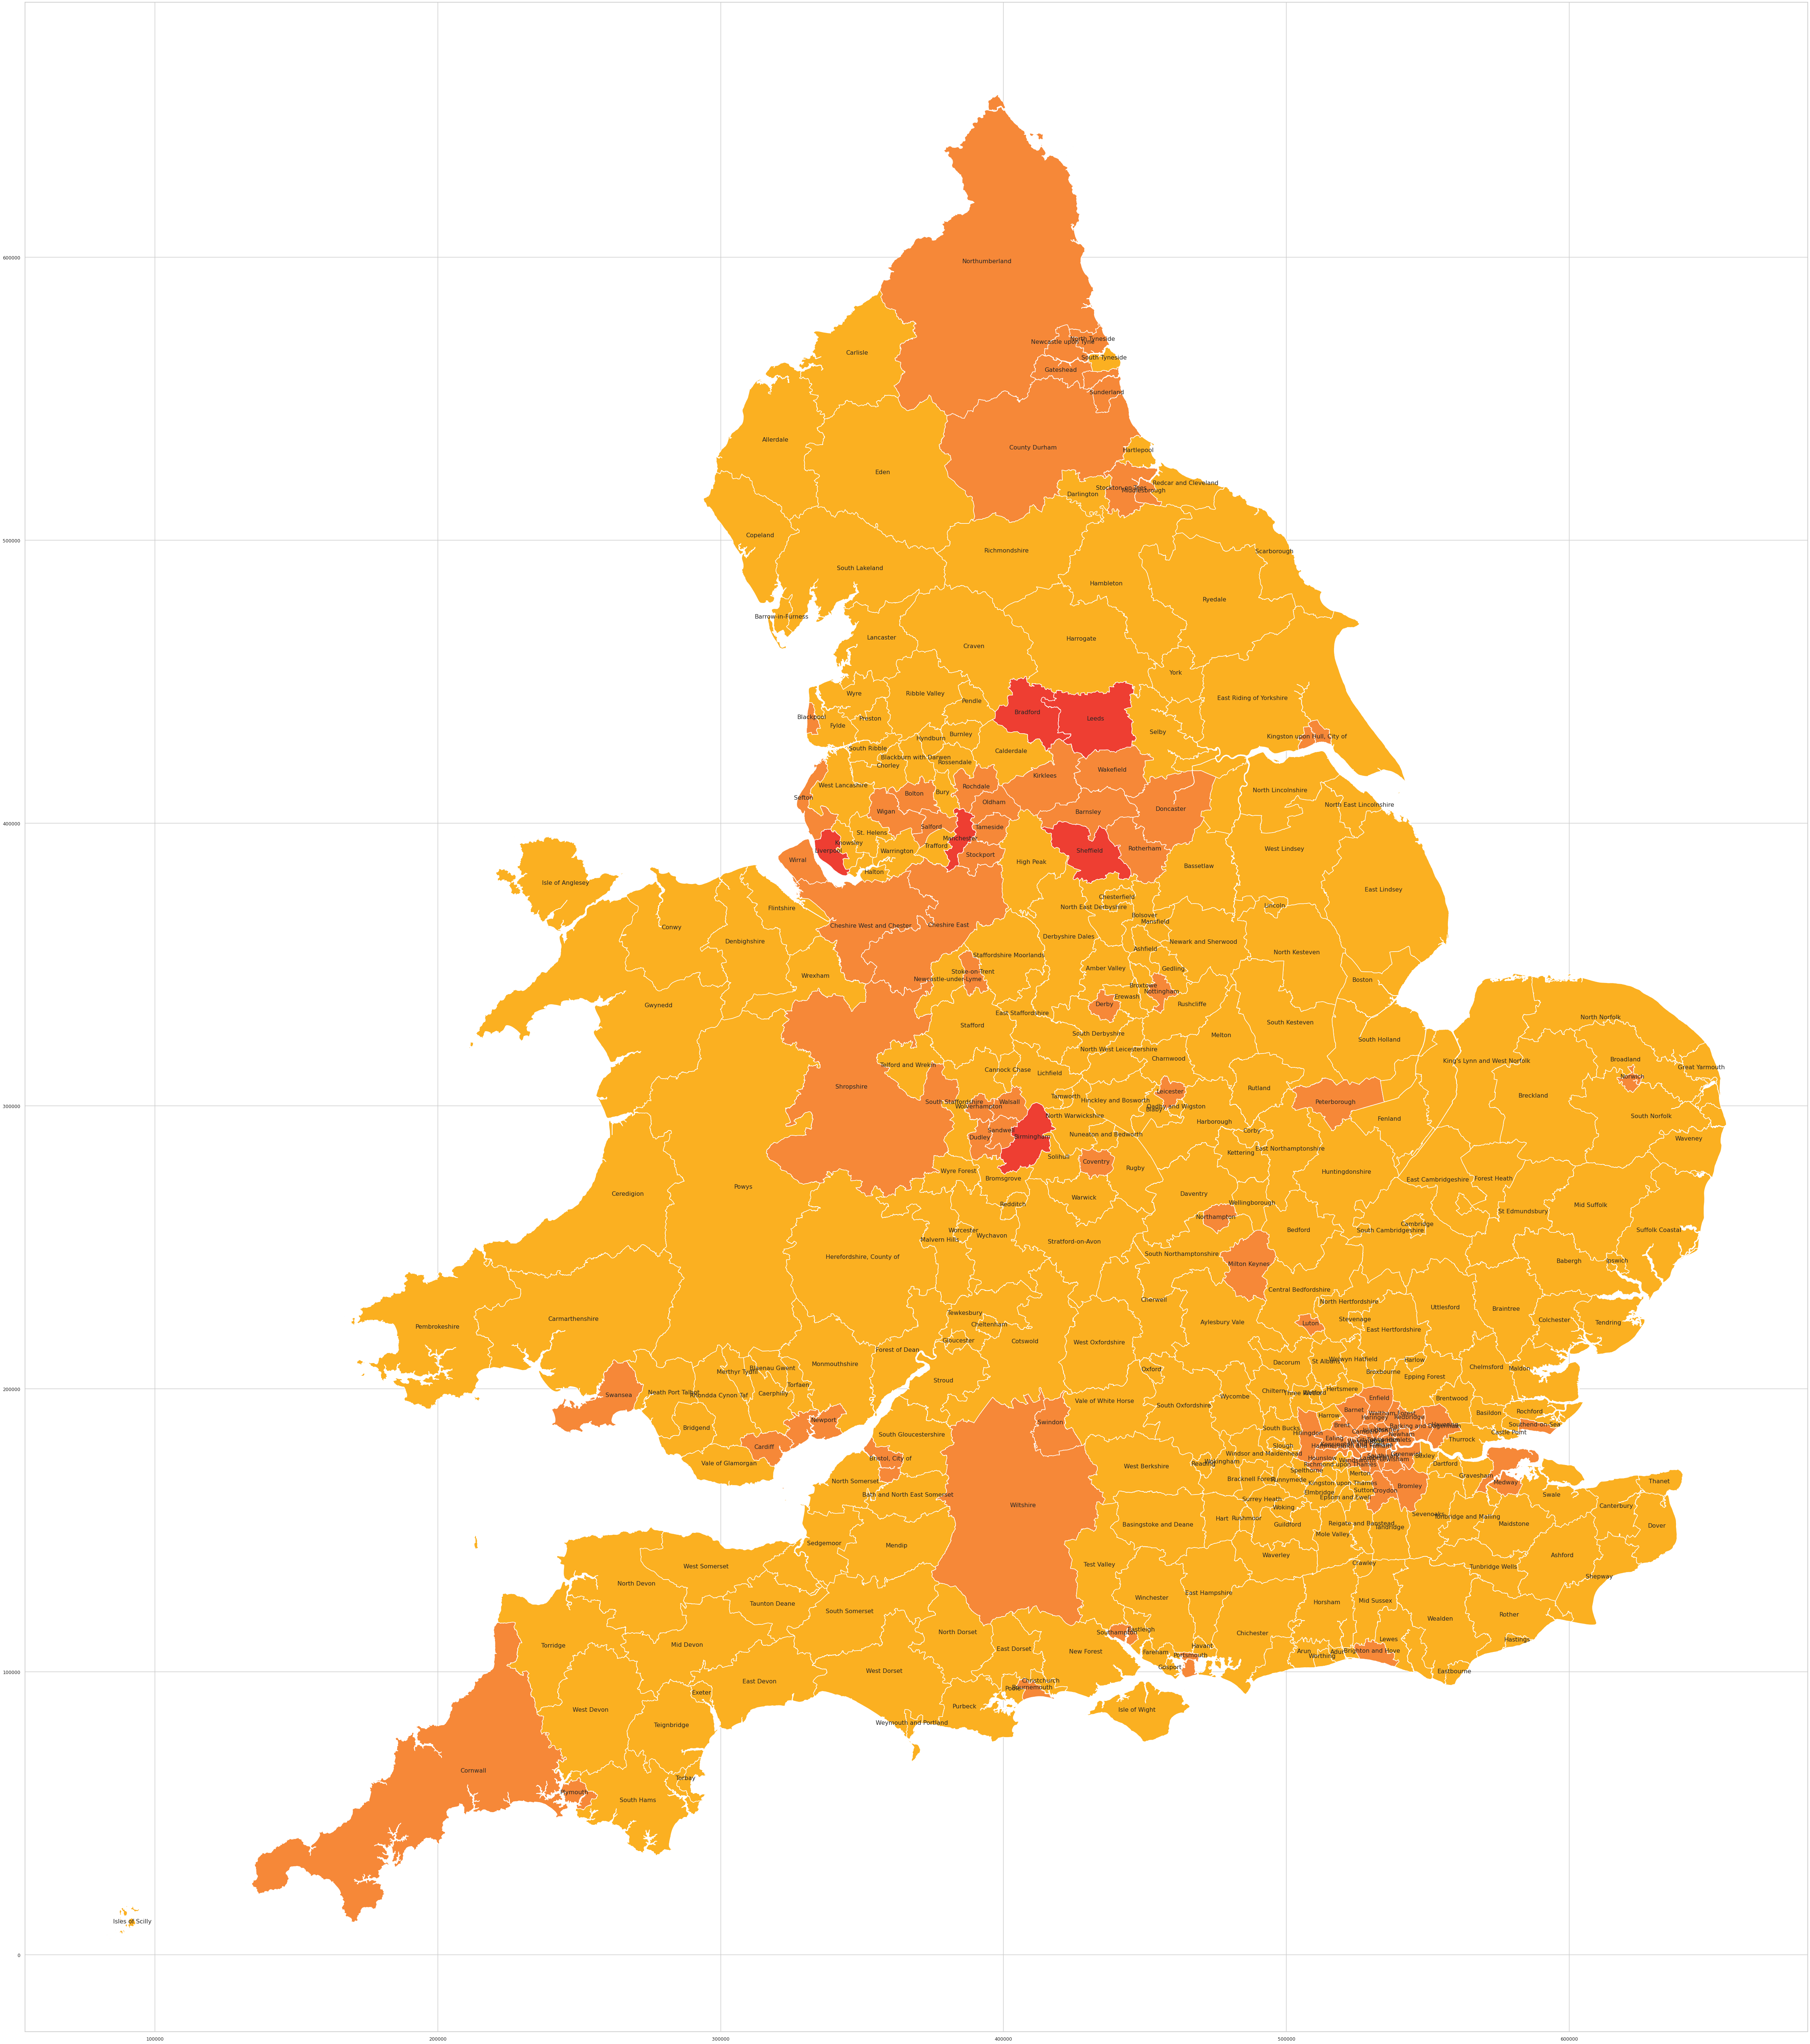

In [165]:
X.plot(color=X['Color'])
for idx, row in X.iterrows():
    plt.annotate(s=row['lad17nm'] ,xy=row['coords'],
                 horizontalalignment='center', fontsize=16)
plt.gcf().set_size_inches(100, 100)

Legend:<br>
Yellow: Low Crime Districts (Cluster 1)<br>
Orange: Moderate Crime Districts (Cluster 2)<br>
Red: Very High Crime Districts (Cluster 3)<br>


From the results we see that the following districts have the Highest Crime Rate:

Birmingham

Bradford

Leeds

Liverpool

Manchester

Sheffield	

# 2. Discovering Frequent Patterns

In [170]:
!pip install apyori
from apyori import apriori

Keeping nescessary columns

In [167]:
X = df_crime[['District', 'Crime']]

Converting dataframe to values

In [171]:
items = []
for i in range(len(X)):
  items.append([str(X.values[i,j]) for j in range(2)])

Running apriori algorithm

In [186]:
final_rule = apriori(items, min_support=0.001, min_length=2)

Converting result to list for parsing

In [187]:
y = list(final_rule)

In [190]:
listRules = [list(y[i][0]) for i in range(0,len(y))]

In [192]:
final_patterns = []
for rule in listRules:
  if len(rule) != 1:
    final_patterns.append(rule)

## Results: Apriori Algorithm

In [196]:
final_patterns

[['Amber Valley', 'Anti-social behaviour'],
 ['Anti-social behaviour', 'Arun'],
 ['Anti-social behaviour', 'Barking and Dagenham'],
 ['Anti-social behaviour', 'Barnet'],
 ['Anti-social behaviour', 'Barnsley'],
 ['Anti-social behaviour', 'Basildon'],
 ['Anti-social behaviour', 'Basingstoke and Deane'],
 ['Anti-social behaviour', 'Bath and North East Somerset'],
 ['Anti-social behaviour', 'Bedford'],
 ['Anti-social behaviour', 'Bexley'],
 ['Anti-social behaviour', 'Birmingham'],
 ['Anti-social behaviour', 'Blackburn with Darwen'],
 ['Anti-social behaviour', 'Blackpool'],
 ['Anti-social behaviour', 'Bolton'],
 ['Anti-social behaviour', 'Bournemouth'],
 ['Anti-social behaviour', 'Bradford'],
 ['Anti-social behaviour', 'Brent'],
 ['Anti-social behaviour', 'Brighton and Hove'],
 ['Anti-social behaviour', 'Bristol, City of'],
 ['Anti-social behaviour', 'Bromley'],
 ['Anti-social behaviour', 'Burnley'],
 ['Anti-social behaviour', 'Bury'],
 ['Anti-social behaviour', 'Caerphilly'],
 ['Anti-socia

The results show frequent pairs of district and crime type that are prevalent